In [ ]:
%pip install duckdb pandas numpy pyspainmobility requests

<h1 align="center"><b>Building a 3-Tier Data Lakehouse for Mobility Analysis in Spain</b></h1>
<h3 align="center"><b style="color:gray">Gold Layer</b></h3>
<h4 align="right">Joan Fernández Navarro & Borja Albert Gramaje</h4>
<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
    <li><a href="#q1"><h5>1. Business Question 1</h5></a></li>
    <li><a href="#q2"><h5>2. Business Question 2</h5></a></li>
</ul>

In [1]:
import os
import duckdb
import requests
import pandas as pd
from pyspainmobility import Mobility, Zones

BASE_PATH = f"{os.getcwd()}/../../raw"
LAKE_LAYER = "gold"

con = duckdb.connect("./../../mobility.db")

def SQL(q):
    """Run SQL (printed for clarity) and return a DataFrame."""
    return con.execute(q).fetchdf()

print("DuckDB version:", con.sql("SELECT version();").fetchone()[0])

DuckDB version: v1.4.2


<h2 id="q1"><b>1. Business Question 1: Typical Day in Mobility for a Reference Year</b></h2>

In [3]:
SQL("""
    CREATE OR REPLACE TABLE gold_typical_day_patterns AS
    WITH daily_aggregates AS (
        SELECT
            zone_level,
            fecha,
            hora,
            is_weekend,
            is_holiday,
            SUM(viajes) AS total_viajes
        FROM silver_od_all
        GROUP BY zone_level, fecha, hora, is_weekend, is_holiday
    ),
    day_types AS (
        SELECT
            zone_level,
            hora,
            CASE
                WHEN is_holiday THEN 'festivo'
                WHEN is_weekend THEN 'fin_semana'
                ELSE 'laborable'
            END AS tipo_dia,
            AVG(total_viajes) AS avg_viajes_por_hora
        FROM daily_aggregates
        GROUP BY zone_level, hora, tipo_dia
    )
    SELECT * FROM day_types
    ORDER BY zone_level, hora, tipo_dia;
""")

,Count
0,72


In [21]:
SQL("""
WITH ranking_horas AS (
    SELECT
        hora,
        tipo_dia,
        zone_level,
        avg_viajes_por_hora,
        RANK() OVER (
            PARTITION BY tipo_dia, zone_level
            ORDER BY avg_viajes_por_hora DESC
        ) as ranking
    FROM gold_typical_day_patterns
)

SELECT * 
FROM ranking_horas
WHERE ranking <= 10
    AND zone_level = 'distritos'
ORDER BY tipo_dia, ranking;
""")

,hora,tipo_dia,zone_level,avg_viajes_por_hora,ranking
0,23,laborable,distritos,7.332878e+14,1
1,1,laborable,distritos,1.810581e+14,2
2,4,laborable,distritos,9.340540e+12,3
3,0,laborable,distritos,5.646365e+12,4
4,3,laborable,distritos,3.307336e+12,5
5,2,laborable,distritos,3.072939e+12,6
6,7,laborable,distritos,1.708643e+12,7
7,8,laborable,distritos,1.580710e+12,8
8,12,laborable,distritos,8.886409e+11,9
9,6,laborable,distritos,8.151396e+11,10


<Axes: title={'center': 'Promedio de viajes por horas'}, xlabel='hora'>

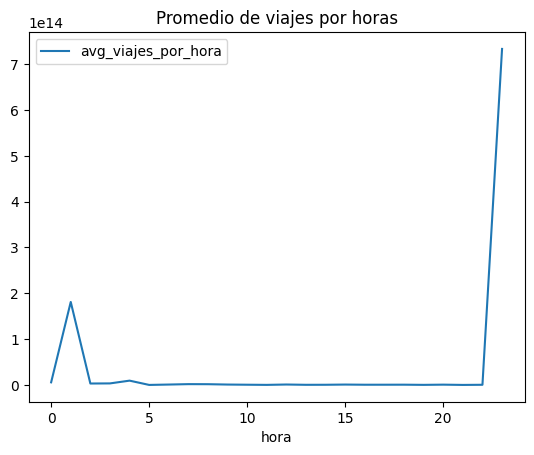

In [16]:
SQL("""
SELECT
    hora,
    tipo_dia,
    avg_viajes_por_hora,
FROM gold_typical_day_patterns
WHERE zone_level = 'distritos'
ORDER BY zone_level, tipo_dia;
""").plot(x = "hora", y = "avg_viajes_por_hora", title = "Promedio de viajes por horas")

<h2 id="q1"><b>1. Business Question 2: Where is Transport Infrastructure Most Lacking?</b></h2>